In [1]:
from __future__ import print_function, division
import mdtraj as md
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from mdtraj.geometry import _geometry
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools    
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
from mdtraj.geometry import _geometry
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from scipy.stats import pearsonr
import json

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [2]:
def subplot_snsheat(data, ax=None, cbar=False, cbar_ax=None):
    from numpy import ndarray
    import seaborn as sns
    if type(data) is ndarray:

        if ax is None:
            ax = plt.gca()

        plot = sns.heatmap(data, cmap='jet', vmin=0,vmax=0.5,ax=ax, cbar=cbar, cbar_ax=None if not cbar else cbar_ax)
        return plot

    else: pass
    
def subplot_imshow(data, xedges, yedges, ax=None):
    
    from numpy import ndarray
    
    if type(data) is ndarray:

        if ax is None:
            ax = plt.gca()
            
        im = ax.imshow(data, interpolation='gaussian', extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
                        cmap='jet', aspect='auto')
        #cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),aspect=10)
        
        return im
    
    else : pass

In [3]:
replica0,nrep=0,8

sequence=  ['LYS1', '','', 'THR4', '','', 'CYS7', '','', 'GLN10', '','', 'ALA13', '','',
            'LEU16', '','', 'SER19', '','', 'ASN22', '','', 'ALA25', '','', 'SER28', '','', 
            'ASN31', '','', 'SER34', '','', 'TYR37', 'NH238']


temperature = [ '300', '322.711', '347.142', '373.421', '401.691', '432.1', '464.812', '500' ]


In [4]:
data_dir='/home/jaya/work/REST3/REST2_REST3/iapp_8reps/data/'

In [6]:
contact_map_p=json.load(open(data_dir+'p_contact_map.json','r'))

In [12]:
np.shape(contact_map_p['rep'][0])

(38, 38)

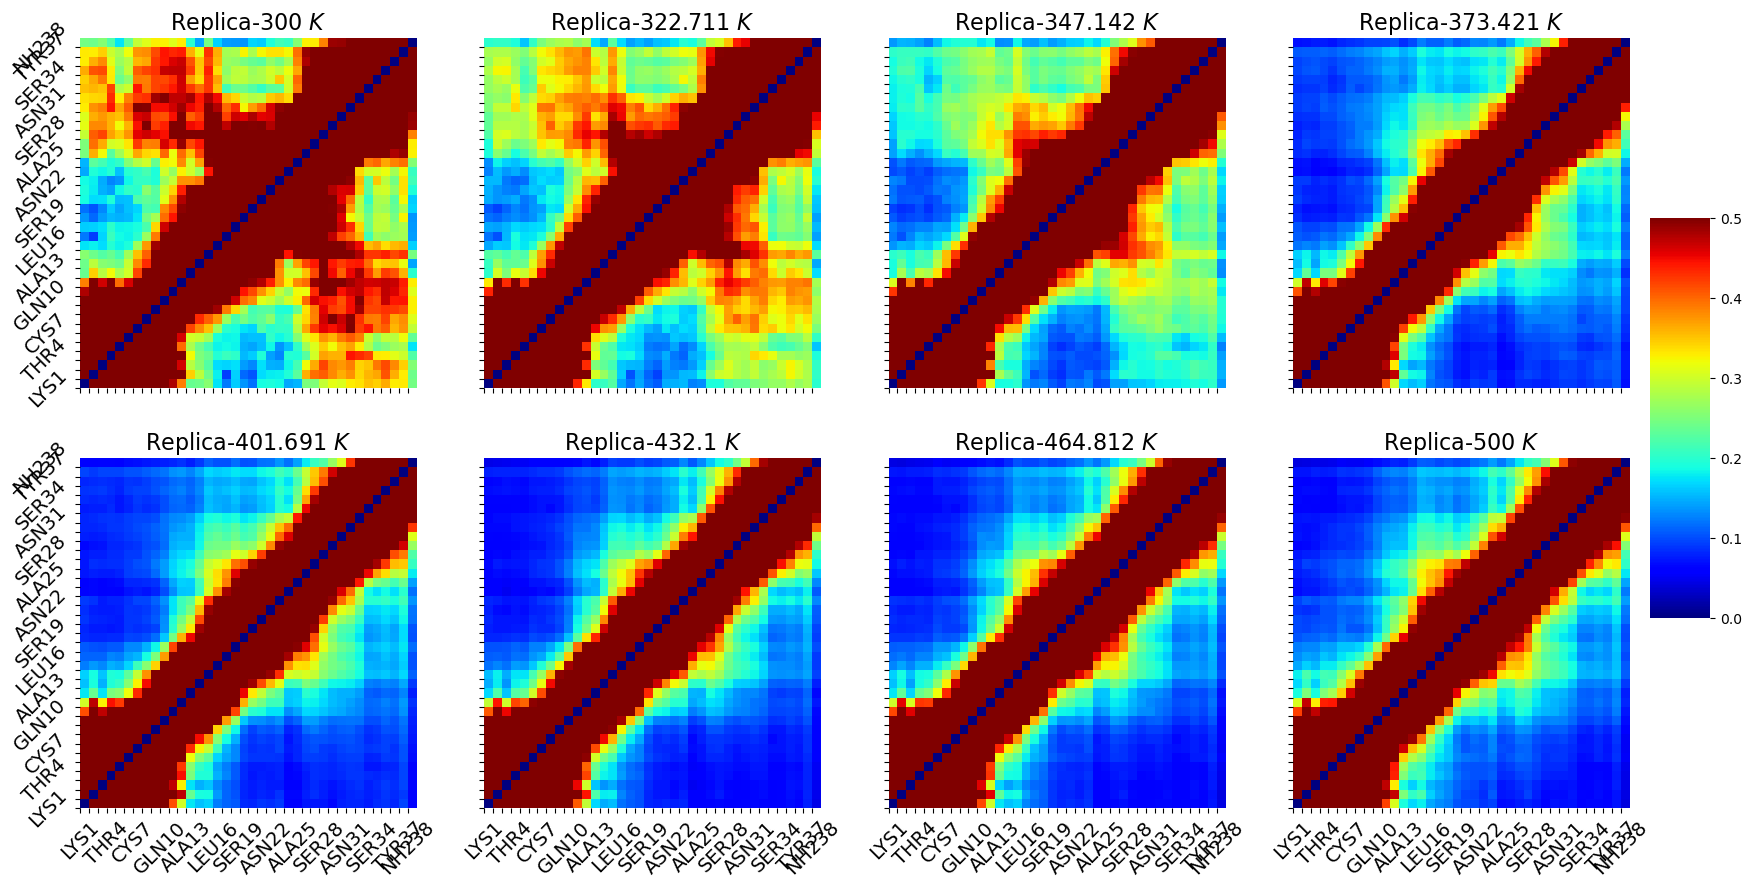

In [15]:
ncol = 4
nrow = int(nrep/ncol)
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(20, 10))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(replica0,replica0+nrep):
    #contact_map = np.loadtxt(f"./Analysis/contact_map.{i}.dat")
    contact_map = np.array(contact_map_p['rep'])[i]
    p, q = np.unravel_index(i,(nrow,ncol))
    cb = i==1
    subplot_snsheat(contact_map, ax=ax[p,q], cbar=cb, cbar_ax=cbar_ax)
    ax[p,q].set_xticks(range(0, 38), sequence, rotation=45, size=14)
    ax[p,q].set_yticks(range(0, 38), sequence, rotation=45, size=14)
    ax[p,q].invert_yaxis()
    ax[p,q].set_title('Replica-'+str(temperature[i])+r' $K$',size=16)
    
plt.savefig(data_dir+'p_contact_maps_rep.png',dpi=310)

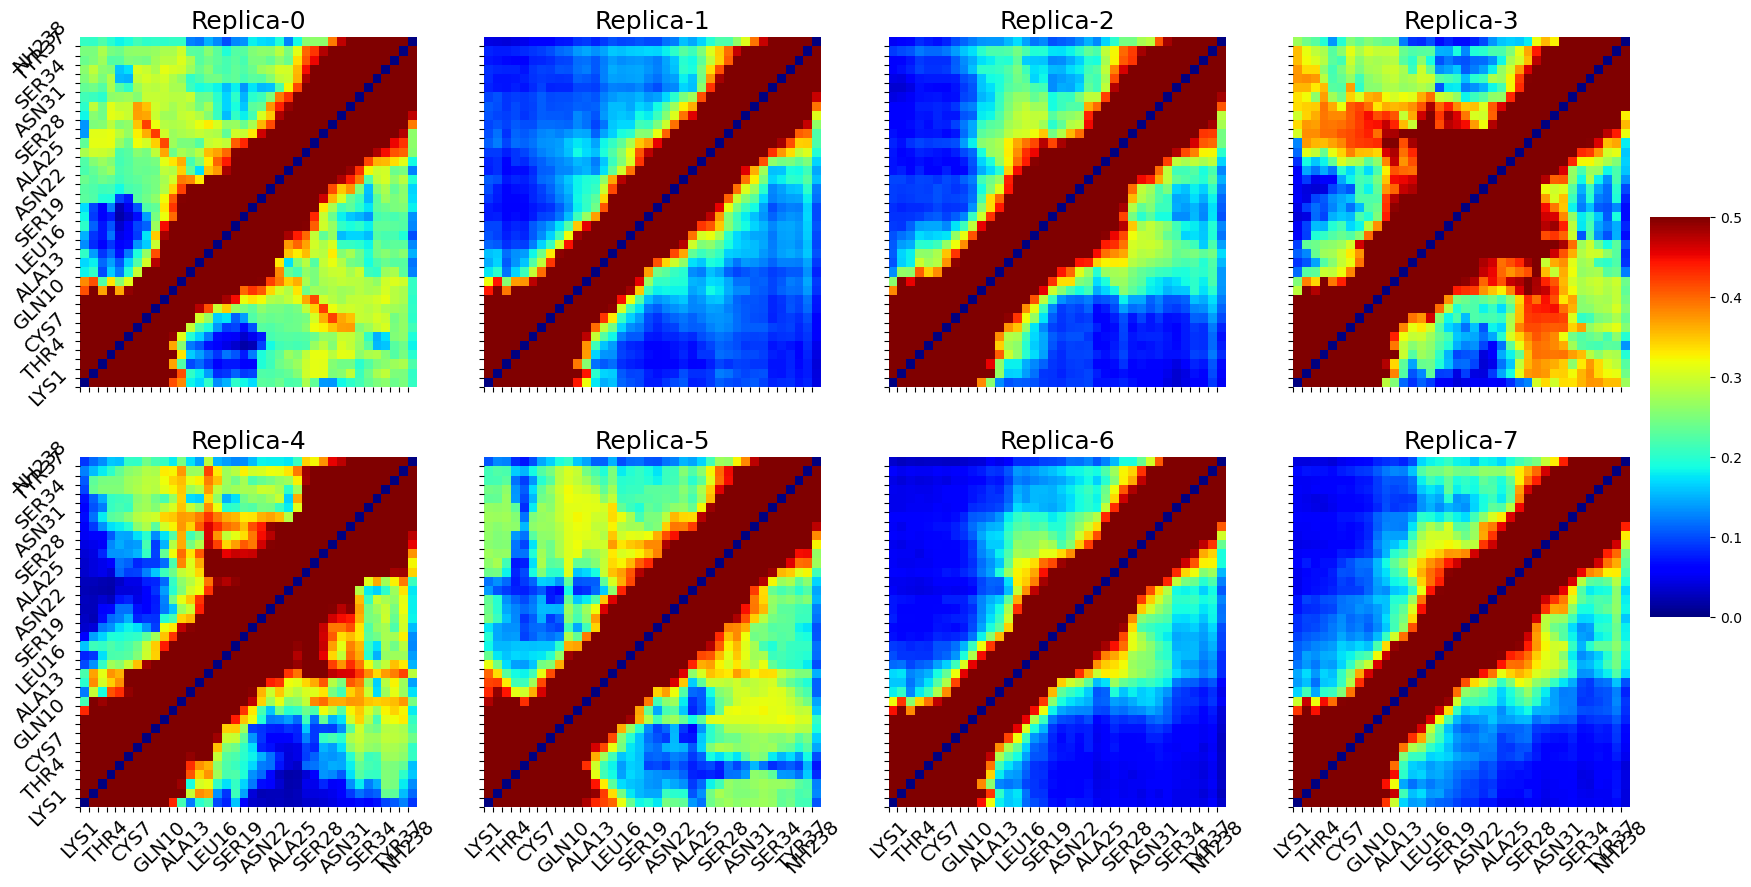

In [16]:
ncol = 4
nrow = int(nrep/ncol)
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(20, 10))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(replica0,replica0+nrep):
    #contact_map = np.loadtxt(f"./Analysis/contact_map.{i}.dat")
    contact_map = np.array(contact_map_p['demux'])[i]
    p, q = np.unravel_index(i,(nrow,ncol))
    cb = i==1
    subplot_snsheat(contact_map, ax=ax[p,q], cbar=cb, cbar_ax=cbar_ax)
    ax[p,q].set_xticks(range(0, 38), sequence, rotation=45, size=14)
    ax[p,q].set_yticks(range(0, 38), sequence, rotation=45, size=14)
    ax[p,q].invert_yaxis()
    ax[p,q].set_title('Replica-'+str(i),size=18)
    
plt.savefig(data_dir+'p_contact_maps_demux.png',dpi=310)

In [5]:
ss=json.load(open(data_dir+'ss_fraction.json','r'))
# sa=json.load(open(data_dir+'sa_timeseries.json','r'))
# pp=json.load(open(data_dir+'pp_timeseries.json','r'))
rg=json.load(open(data_dir+'rg_timeseries.json','r'))

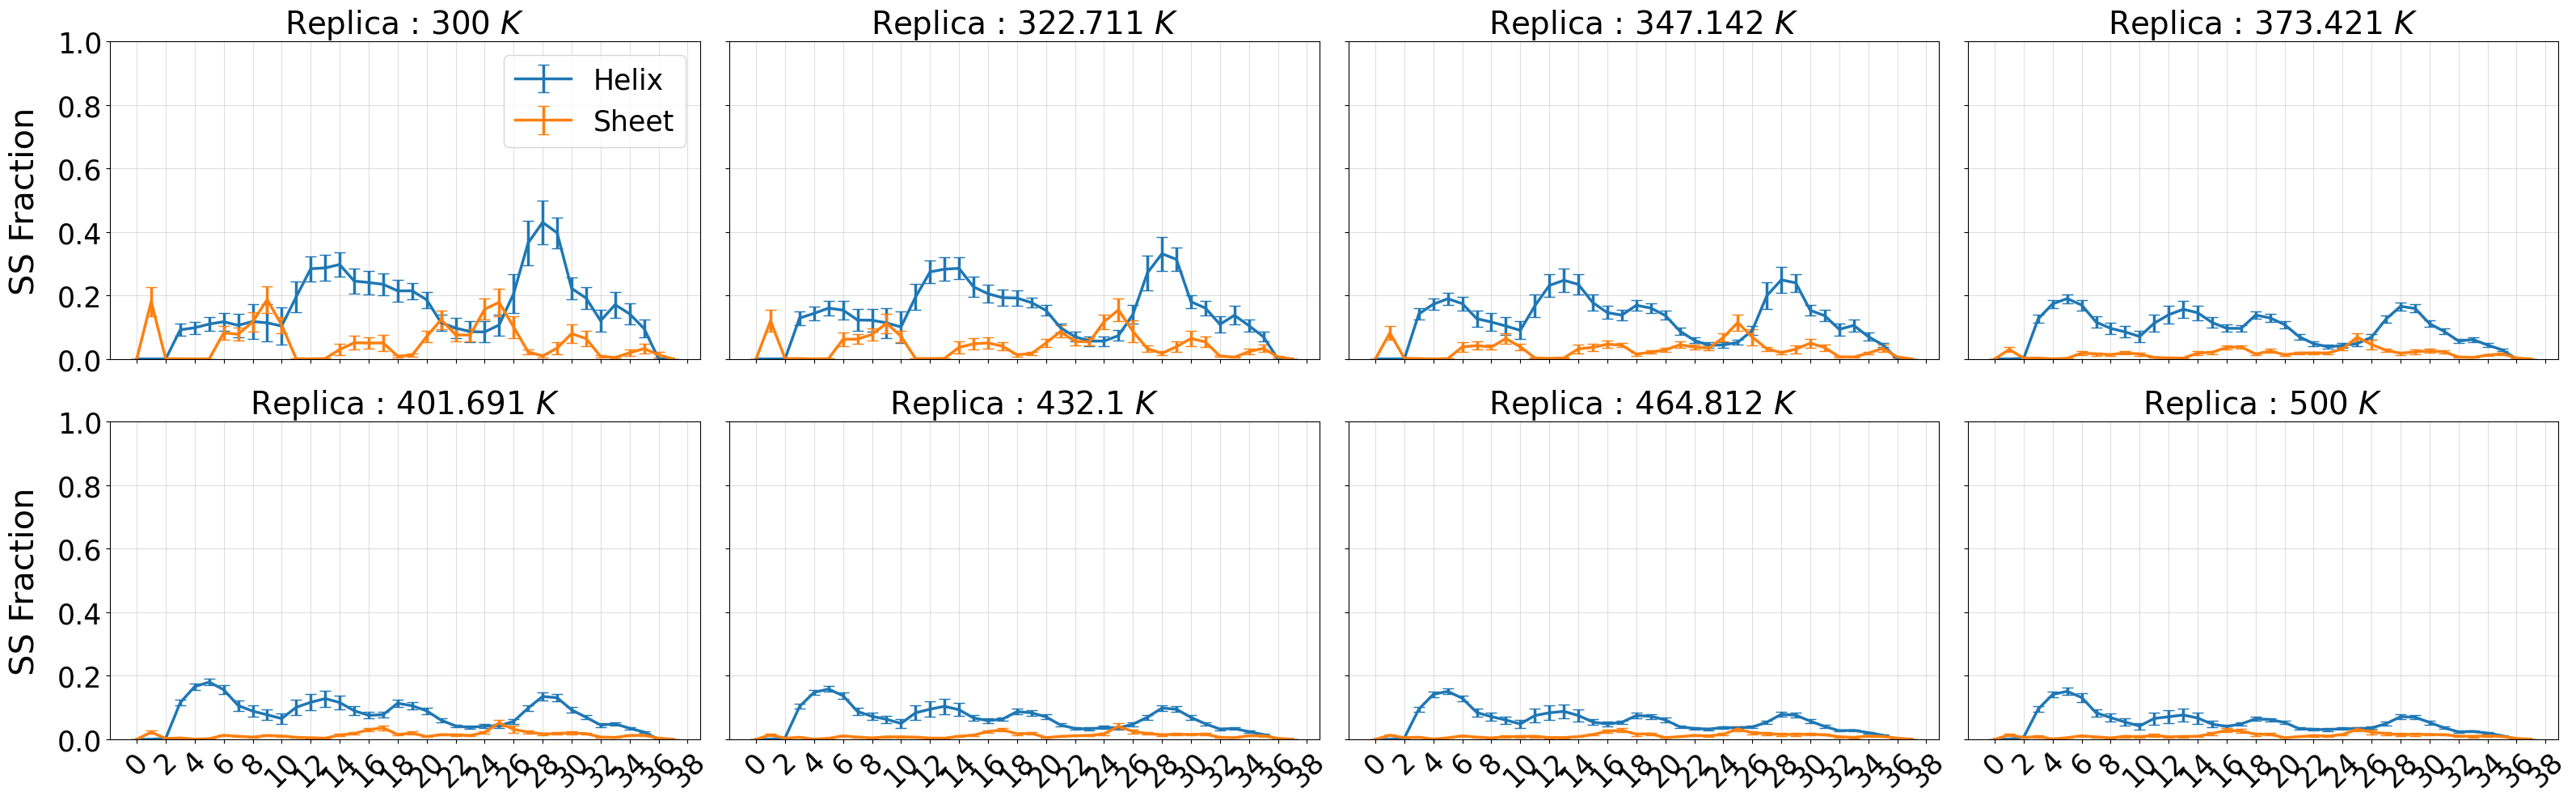

In [7]:
fig, ax = plt.subplots(2, 4, figsize=(32, 10), sharex=True, sharey=True)

for val in range(nrep):
    p, q = np.unravel_index(val,(2,4))
    
    ax[p,q].errorbar(range(0,38),np.array(ss['rep']['helix'])[val].T[0],
                     yerr=np.array(ss['rep']['helix'])[val].T[1], capsize=5,label='Helix',linewidth=2.5)
    ax[p,q].errorbar(range(0,38),np.array(ss['rep']['sheet'])[val].T[0],
                     yerr=np.array(ss['rep']['sheet'])[val].T[1], capsize=5,label='Sheet',linewidth=2.5)
    
    ax[p,q].tick_params(labelsize=25)
    ax[p,q].grid(alpha=0.4)
    plt.setp(ax[p,q].get_xticklabels(), rotation=45)
    ax[p,q].set_ylim(0,1.0)
    ax[p,q].set_xticks(range(0,39,2))
    ax[p,q].set_title('Replica : '+temperature[val]+' $K$',size=28)
    
    if val == 0:
        ax[p,q].legend(loc=1,prop={'size': 25})
    
    if not q : ax[p,q].set_ylabel("SS Fraction", size=30, labelpad=15)
    if p == 4-1 : ax[p,q].set_xlabel('Protein Residues', size=30, labelpad=15)
    
#     text_=r'$K_{D}$'+' : '+str(round(np.array(bf_kd['rep'][2])[0][val],2))+r'$\pm$'+str(round(np.array(bf_kd['rep'][3])[0][val],2))
#     ax[p,q].text(120.3, 0.63, text_, fontsize = 28)
    
plt.tight_layout()
plt.savefig(data_dir+'ss_fraction_rep.png',dpi=210)

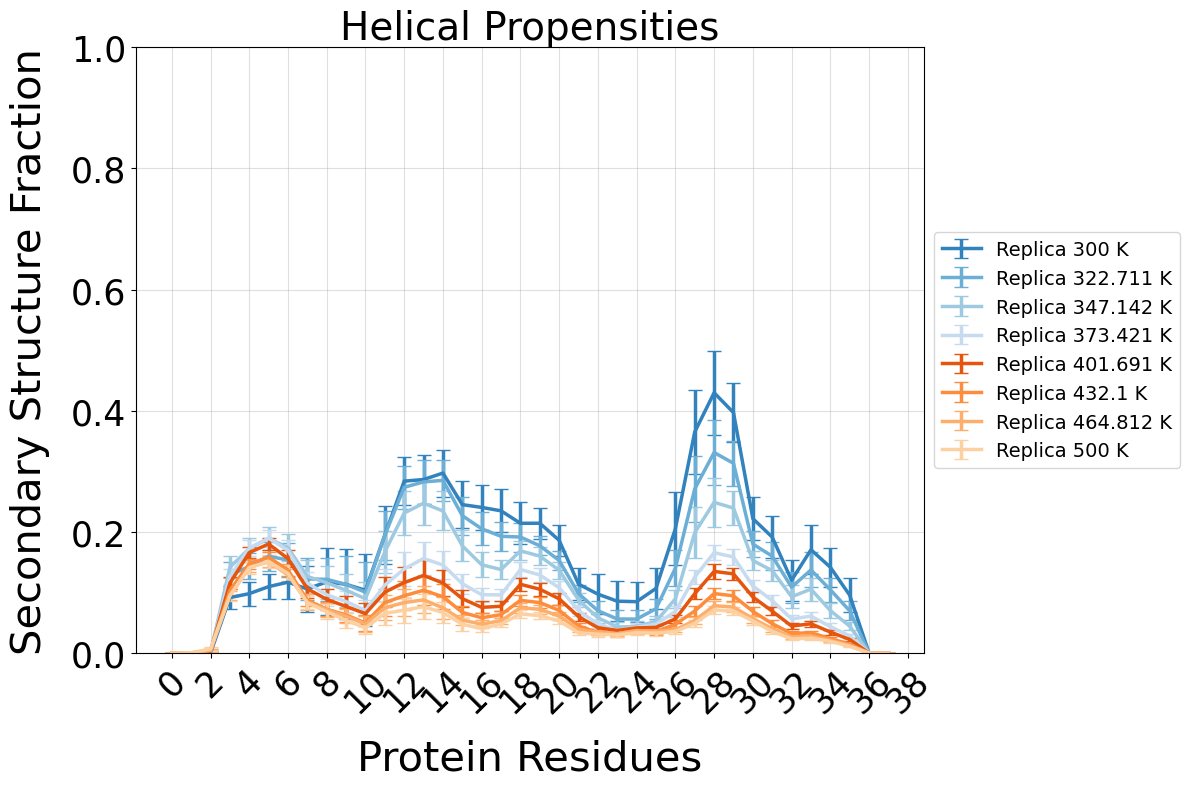

In [8]:
plt.figure(figsize=(12,8))

for val in range(nrep):
    
    plt.errorbar(range(0,38),np.array(ss['rep']['helix'])[val].T[0],yerr=np.array(ss['rep']['helix'])[val].T[1],
                 capsize=5,label='Replica '+str(temperature[val])+' K',linewidth=2.5,c=plt.cm.tab20c(val))
    
    
plt.tick_params(labelsize=25)
plt.grid(alpha=0.4)
plt.ylim(0,1.0)
plt.xticks(range(0,39,2),rotation=45)
plt.title('Helical Propensities',size=28)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14) 
plt.ylabel("Secondary Structure Fraction", size=30, labelpad=15)
plt.xlabel('Protein Residues', size=30, labelpad=15)
    
#     text_=r'$K_{D}$'+' : '+str(round(np.array(bf_kd['rep'])[2][val],2))+r'$\pm$'+str(round(np.array(bf_kd['rep'])[3][val],2))
#     ax[p,q].text(120.3, 0.63, text_, fontsize = 28)
    
plt.tight_layout()
plt.savefig(data_dir+'ss_fraction_helix_rep.png',dpi=210)

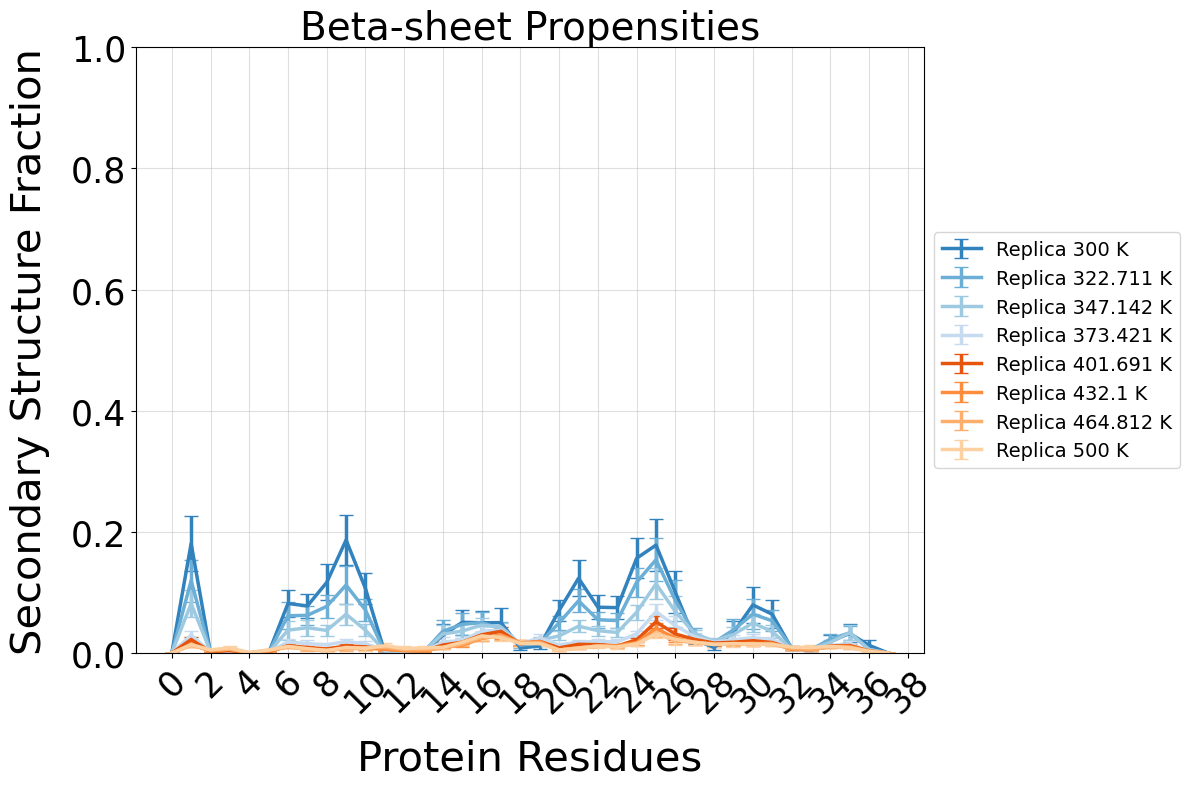

In [9]:
plt.figure(figsize=(12,8))

for val in range(nrep):
    
    plt.errorbar(range(0,38),np.array(ss['rep']['sheet'])[val].T[0],yerr=np.array(ss['rep']['sheet'])[val].T[1],
                 capsize=5,label='Replica '+str(temperature[val])+' K',linewidth=2.5,c=plt.cm.tab20c(val))
    
plt.tick_params(labelsize=25)
plt.grid(alpha=0.4)
plt.ylim(0,1.0)
plt.xticks(range(0,39,2),rotation=45)
plt.title('Beta-sheet Propensities',size=28)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14) 
plt.ylabel("Secondary Structure Fraction", size=30, labelpad=15)
plt.xlabel('Protein Residues', size=30, labelpad=15)

    
plt.tight_layout()
plt.savefig(data_dir+'ss_fraction_sheet_rep.png',dpi=210)

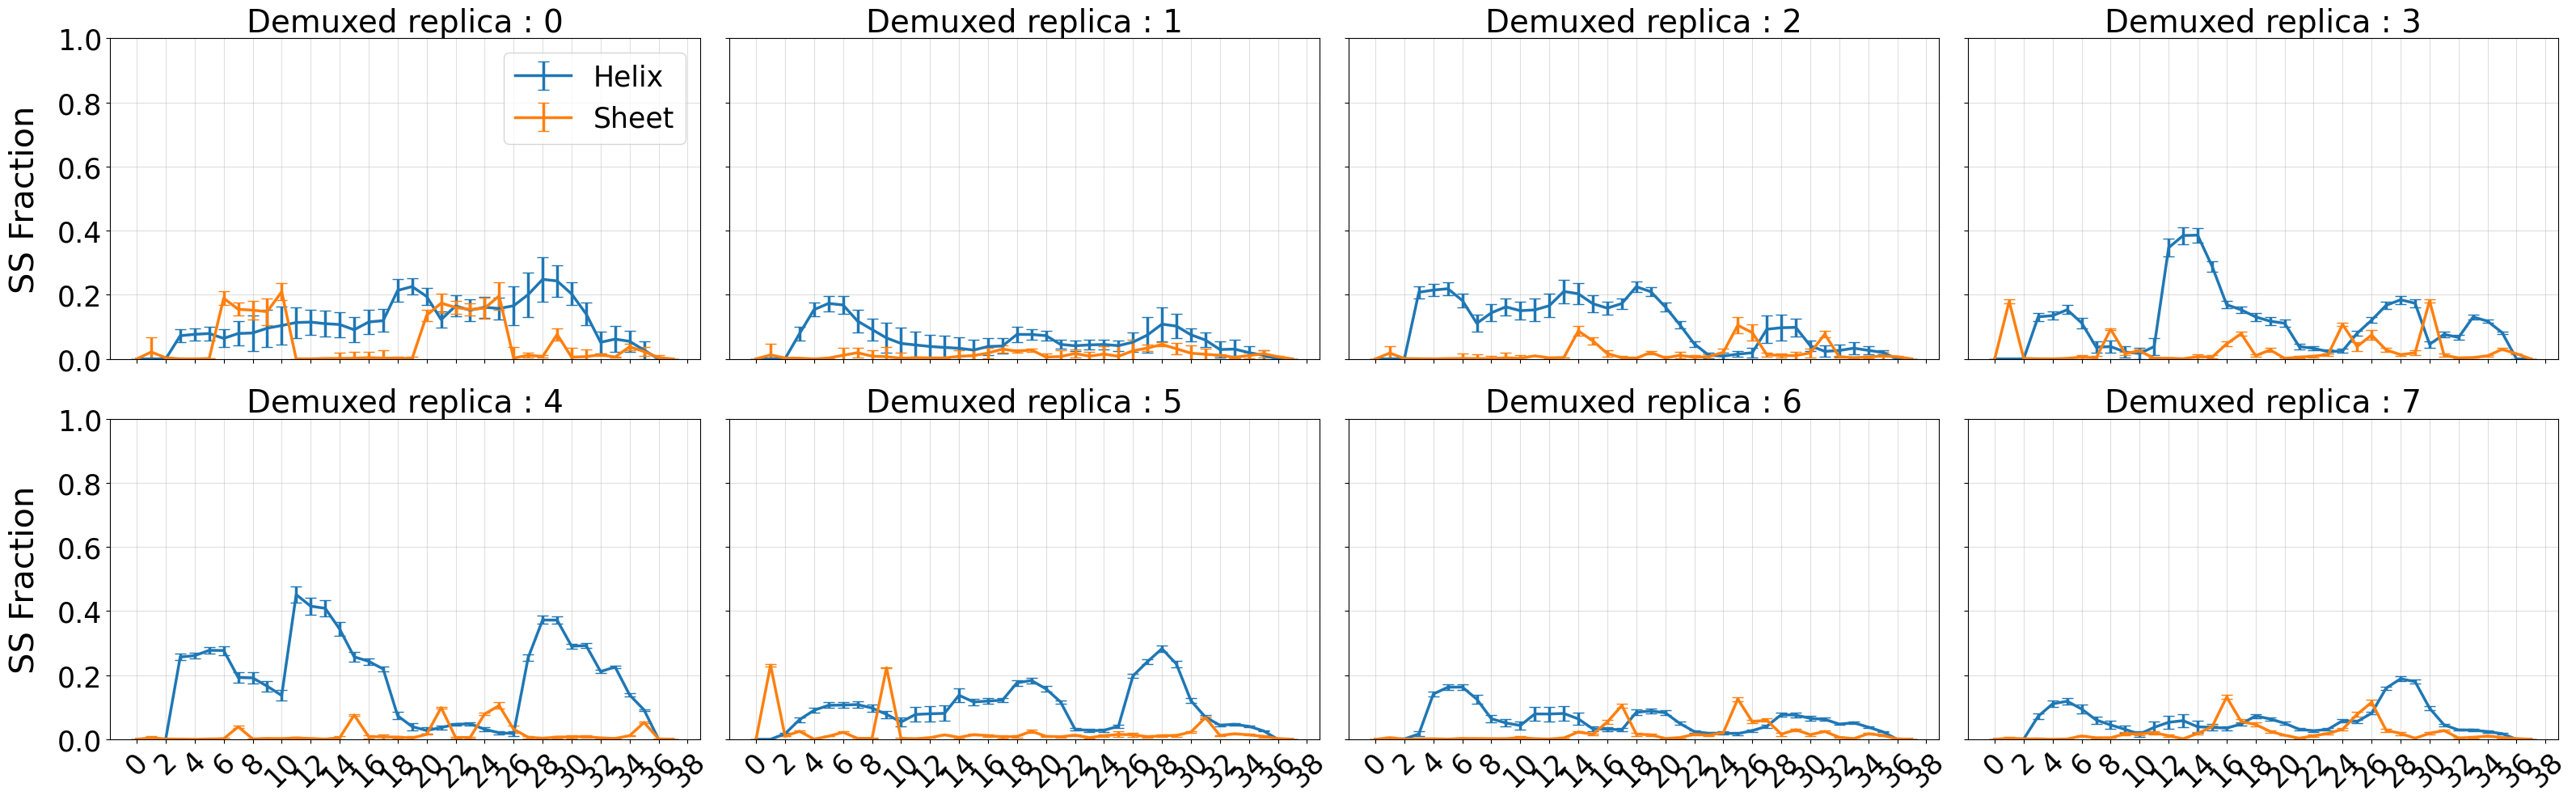

In [10]:
fig, ax = plt.subplots(2, 4, figsize=(32, 10), sharex=True, sharey=True)

for val in range(nrep):
    p, q = np.unravel_index(val,(2, 4))
    
    ax[p,q].errorbar(range(0,38),np.array(ss['demux']['helix'])[val].T[0],
                     yerr=np.array(ss['rep']['helix'])[val].T[1], capsize=5,label='Helix',linewidth=2.5)
    ax[p,q].errorbar(range(0,38),np.array(ss['demux']['sheet'])[val].T[0],
                     yerr=np.array(ss['rep']['sheet'])[val].T[1], capsize=5,label='Sheet',linewidth=2.5)
    
    ax[p,q].tick_params(labelsize=25)
    ax[p,q].grid(alpha=0.4)
    plt.setp(ax[p,q].get_xticklabels(), rotation=45)
    ax[p,q].set_ylim(0,1.0)
    ax[p,q].set_xticks(range(0,39,2))
    ax[p,q].set_title('Demuxed replica : '+str(val),size=28)
    
    if val == 0:
        ax[p,q].legend(loc=1,prop={'size': 25})
    
    if not q : ax[p,q].set_ylabel("SS Fraction", size=30, labelpad=15)
    if p == 4-1 : ax[p,q].set_xlabel('Protein Residues', size=30, labelpad=15)
    
#     text_=r'$K_{D}$'+' : '+str(round(np.array(bf_kd['rep'])[2][val],2))+r'$\pm$'+str(round(np.array(bf_kd['rep'])[3][val],2))
#     ax[p,q].text(120.3, 0.63, text_, fontsize = 28)
    
plt.tight_layout()

plt.savefig(data_dir+'ss_fraction_demux.png',dpi=210)

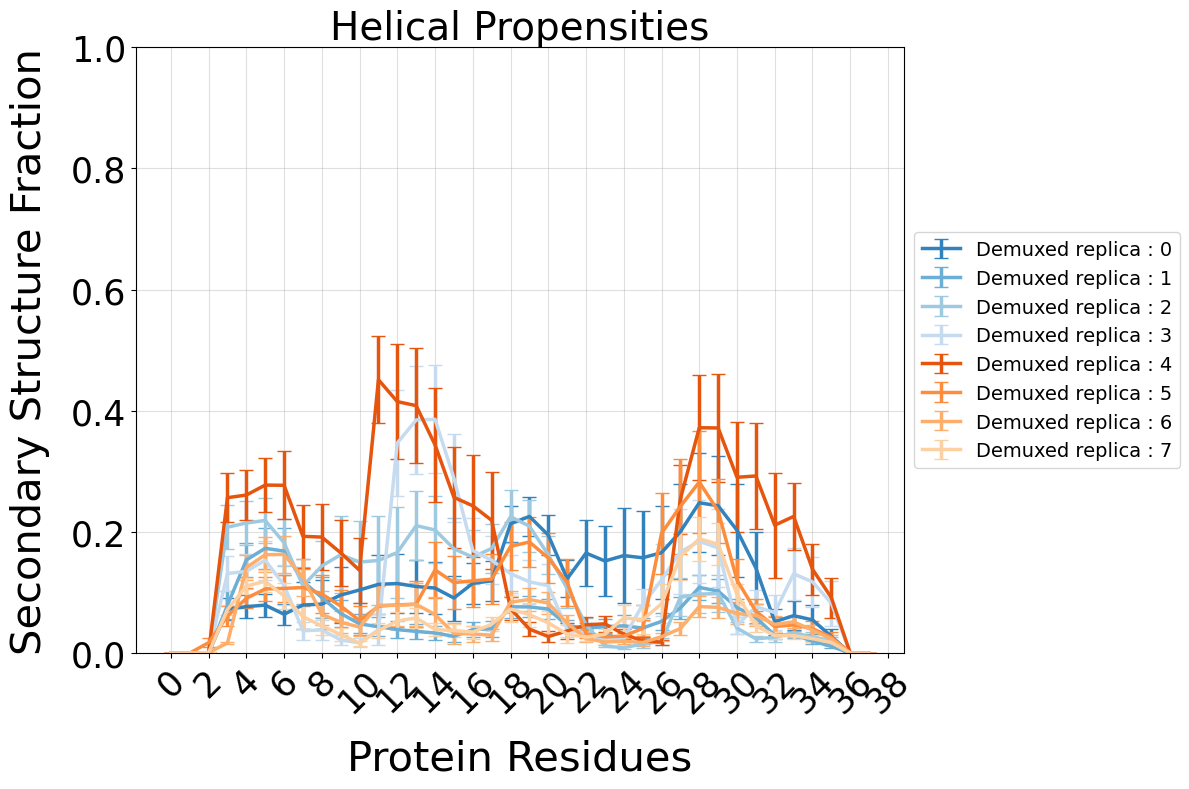

In [11]:
plt.figure(figsize=(12,8))

for val in range(nrep):
    
    plt.errorbar(range(0,38),np.array(ss['demux']['helix'])[val].T[0],yerr=np.array(ss['demux']['helix'])[val].T[1],
                 capsize=5,label='Demuxed replica : '+str(val),linewidth=2.5,c=plt.cm.tab20c(val))
    
    
plt.tick_params(labelsize=25)
plt.grid(alpha=0.4)
plt.ylim(0,1.0)
plt.xticks(range(0,39,2),rotation=45)
plt.title('Helical Propensities',size=28)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14) 
plt.ylabel("Secondary Structure Fraction", size=30, labelpad=15)
plt.xlabel('Protein Residues', size=30, labelpad=15)
    
#     text_=r'$K_{D}$'+' : '+str(round(np.array(bf_kd['rep'])[2][val],2))+r'$\pm$'+str(round(np.array(bf_kd['rep'])[3][val],2))
#     ax[p,q].text(120.3, 0.63, text_, fontsize = 28)
    
plt.tight_layout()
plt.savefig(data_dir+'ss_fraction_helix_demux.png',dpi=210)

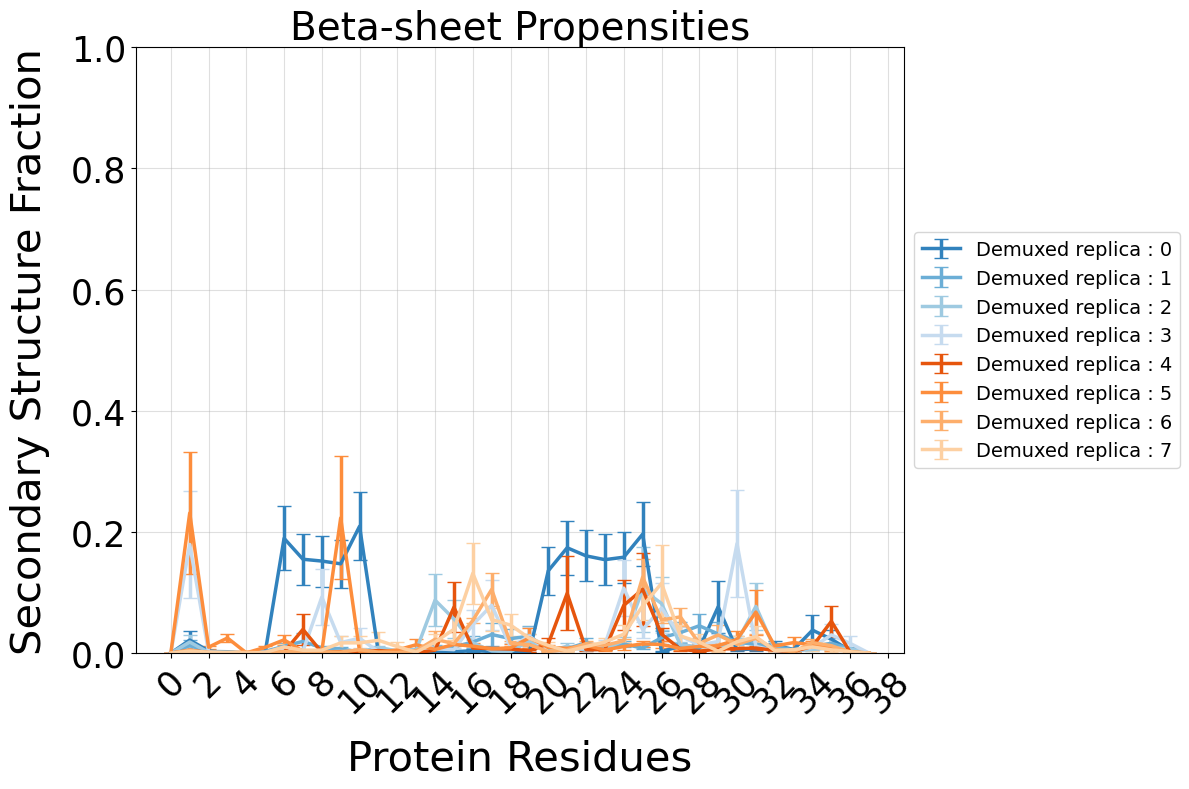

In [12]:
plt.figure(figsize=(12,8))

for val in range(nrep):
    
    plt.errorbar(range(0,38),np.array(ss['demux']['sheet'])[val].T[0],yerr=np.array(ss['demux']['sheet'])[val].T[1],
                 capsize=5,label='Demuxed replica : '+str(val),linewidth=2.5,c=plt.cm.tab20c(val))
    
plt.tick_params(labelsize=25)
plt.grid(alpha=0.4)
plt.ylim(0,1.0)
plt.xticks(range(0,39,2),rotation=45)
plt.title('Beta-sheet Propensities',size=28)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14) 
plt.ylabel("Secondary Structure Fraction", size=30, labelpad=15)
plt.xlabel('Protein Residues', size=30, labelpad=15)

    
plt.tight_layout()
plt.savefig(data_dir+'ss_fraction_sheet_demux.png',dpi=210)

In [13]:
phipsi=json.load(open(data_dir+'phipsi.json','r'))

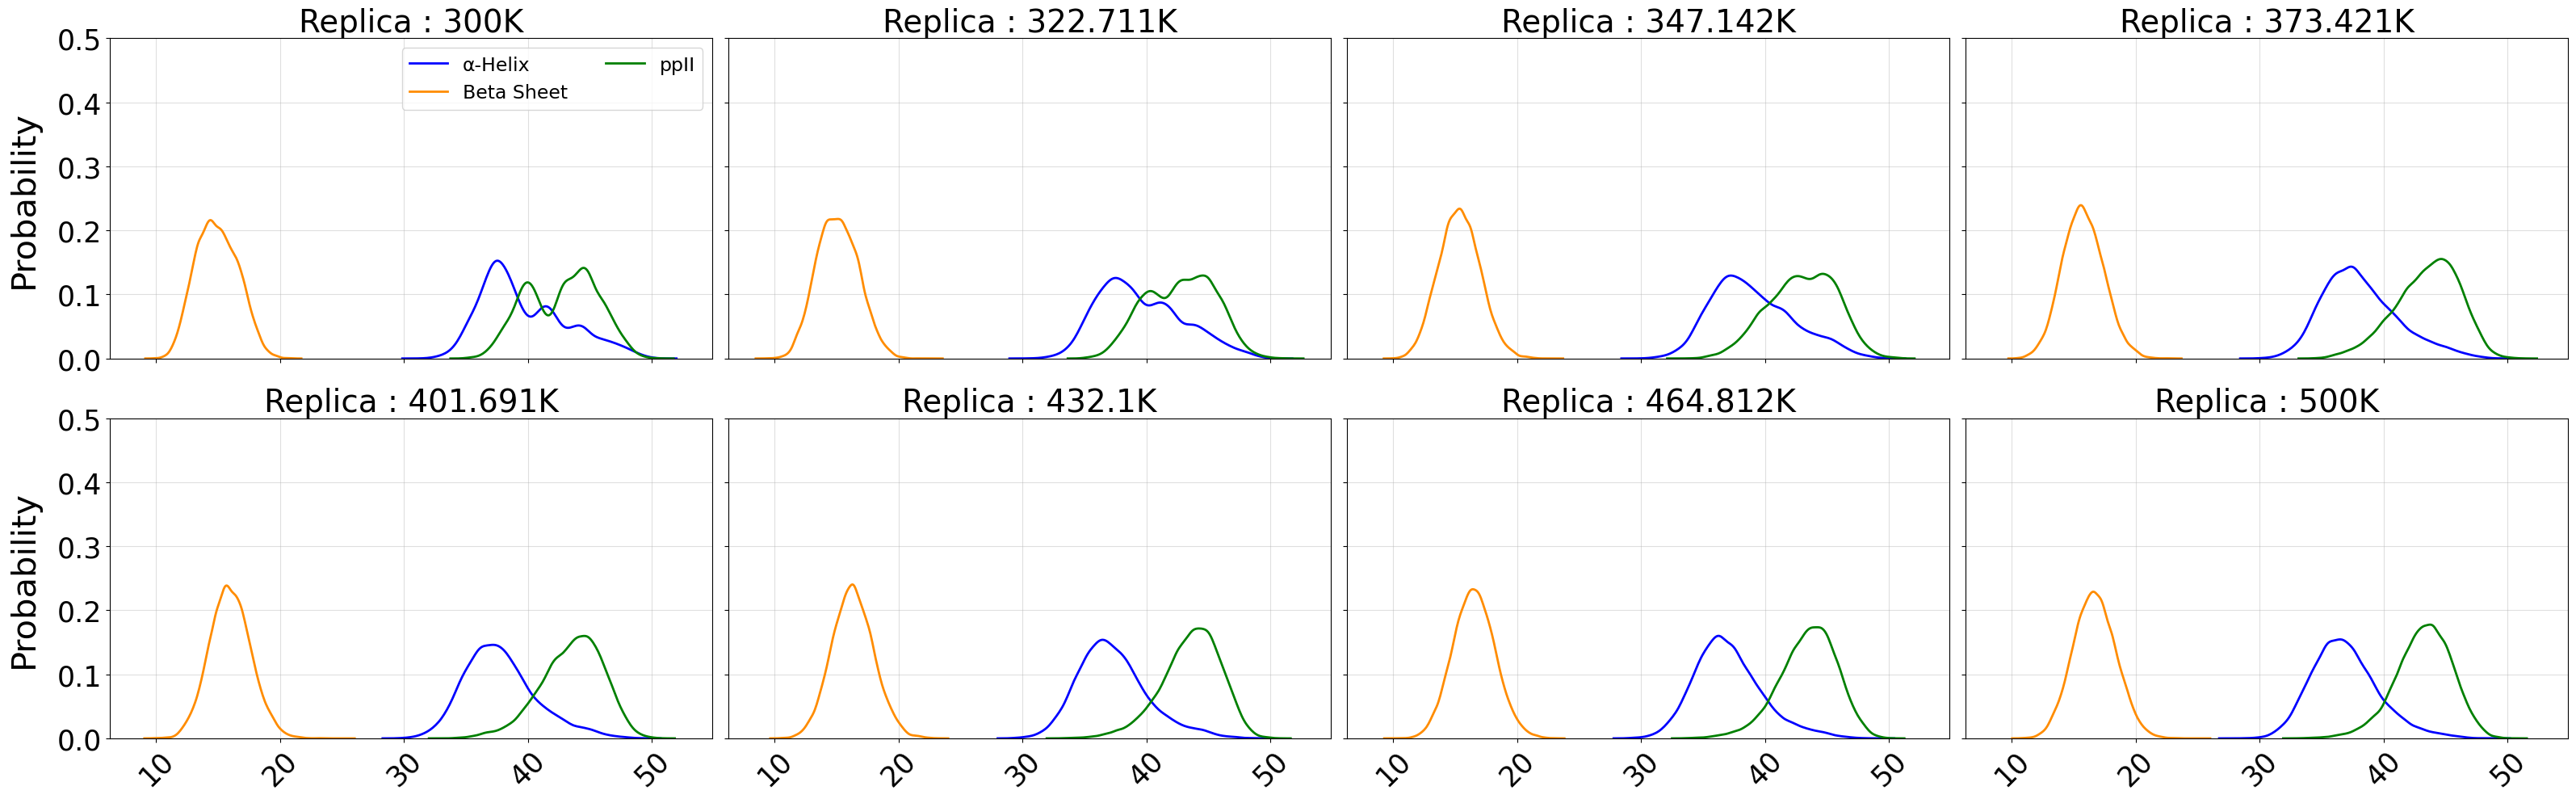

In [14]:
fig, ax = plt.subplots(2, 4, figsize=(32, 10), sharex=True, sharey=True)


for val in range(nrep):
    p, q = np.unravel_index(val,(2, 4))
    
    sns.kdeplot(data=np.array(phipsi['rep'][val])[0], label='α-Helix',ax=ax[p,q], linewidth=2,c='b')
    sns.kdeplot(data=np.array(phipsi['rep'][val])[1], label='Beta Sheet',ax=ax[p,q], linewidth=2,c='darkorange')
    sns.kdeplot(data=np.array(phipsi['rep'][val])[2], label='ppII',ax=ax[p,q], linewidth=2,c='g')
    
    ax[p, q].set_ylim(0,0.5)
    #ax[p, q].set_xticks(range(121,142,2))
    ax[p,q].tick_params(labelsize=25)
    ax[p,q].grid(alpha=0.4)
    plt.setp(ax[p,q].get_xticklabels(), rotation=45)
    
    if val == 0:
        ax[p,q].legend(loc=1,prop={'size': 17},ncol=2)

    a='Replica : '+temperature[val]+'K'
    ax[p,q].set_title(a,size=28)
    
#     text_=r'$K_{D}$'+' : '+str(round(np.array(bf_kd['rep'])[2][val],2))+r'$\pm$'+str(round(np.array(bf_kd['rep'])[3][val],2))
#     ax[p,q].text(120.3, 0.43, text_, fontsize = 26)
    
    if not q : ax[p,q].set_ylabel("Probability", size=30, labelpad=15)
    if p == 4-1 : ax[p,q].set_xlabel('Alphabeta RMSD', size=30, labelpad=15)
        


        
plt.tight_layout()

plt.savefig(data_dir+'ss_rmsd_rep.png',dpi=210)


In [24]:
sim_time=np.asarray(rg['rep']).shape[1]*80/(10**6)
time=np.linspace(0, sim_time, np.asarray(rg['rep']).shape[1])

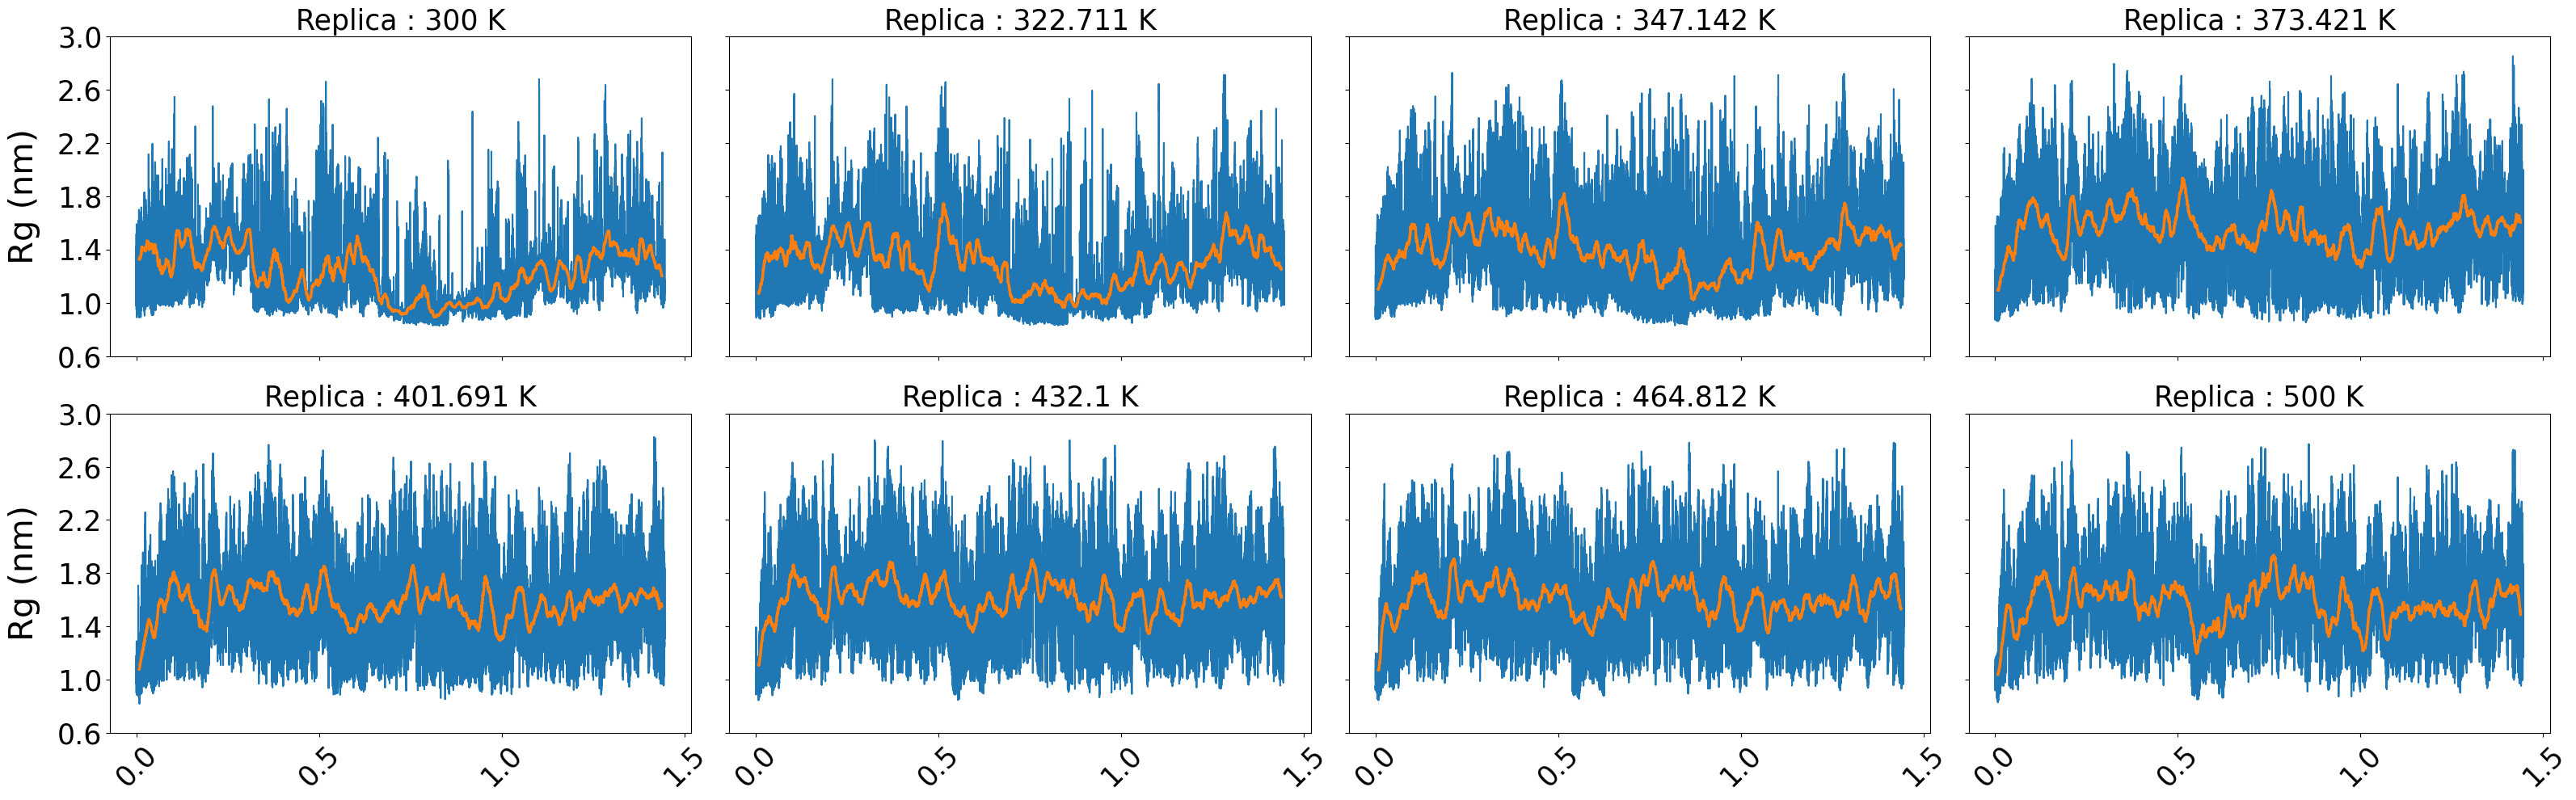

In [27]:
fig, ax = plt.subplots(2, 4, figsize=(32, 10), sharex=True, sharey=True)

i='rep'
N=200

for val in range(nrep):
    p, q = np.unravel_index(val,(2, 4))
    
    ax[p,q].plot(time,np.array(rg[i])[val])
    ax[p,q].plot(np.convolve(time, np.ones(N)/N, mode='valid'),
                 np.convolve(np.array(rg[i])[val], np.ones(N)/N, mode='valid'),linewidth=2.5)
    
    ax[p,q].tick_params(labelsize=25)
    plt.setp(ax[p,q].get_xticklabels(), rotation=45)
    ax[p,q].set_ylim(0.6,3.0)
    #ax[p,q].set_xticks(range(0,142,2))
    ax[p,q].set_yticks(np.arange(0.6,3.2,0.4))
    
    ax[p,q].set_title('Replica : '+temperature[val]+' K',size=25)

    if not q : ax[p,q].set_ylabel("Rg (nm)", size=30, labelpad=15)
    if p == 4-1 : ax[p,q].set_xlabel('Time ($\mu$s)', size=30, labelpad=15)
        
plt.tight_layout()

plt.savefig(data_dir+'rg_rep.png',dpi=210)

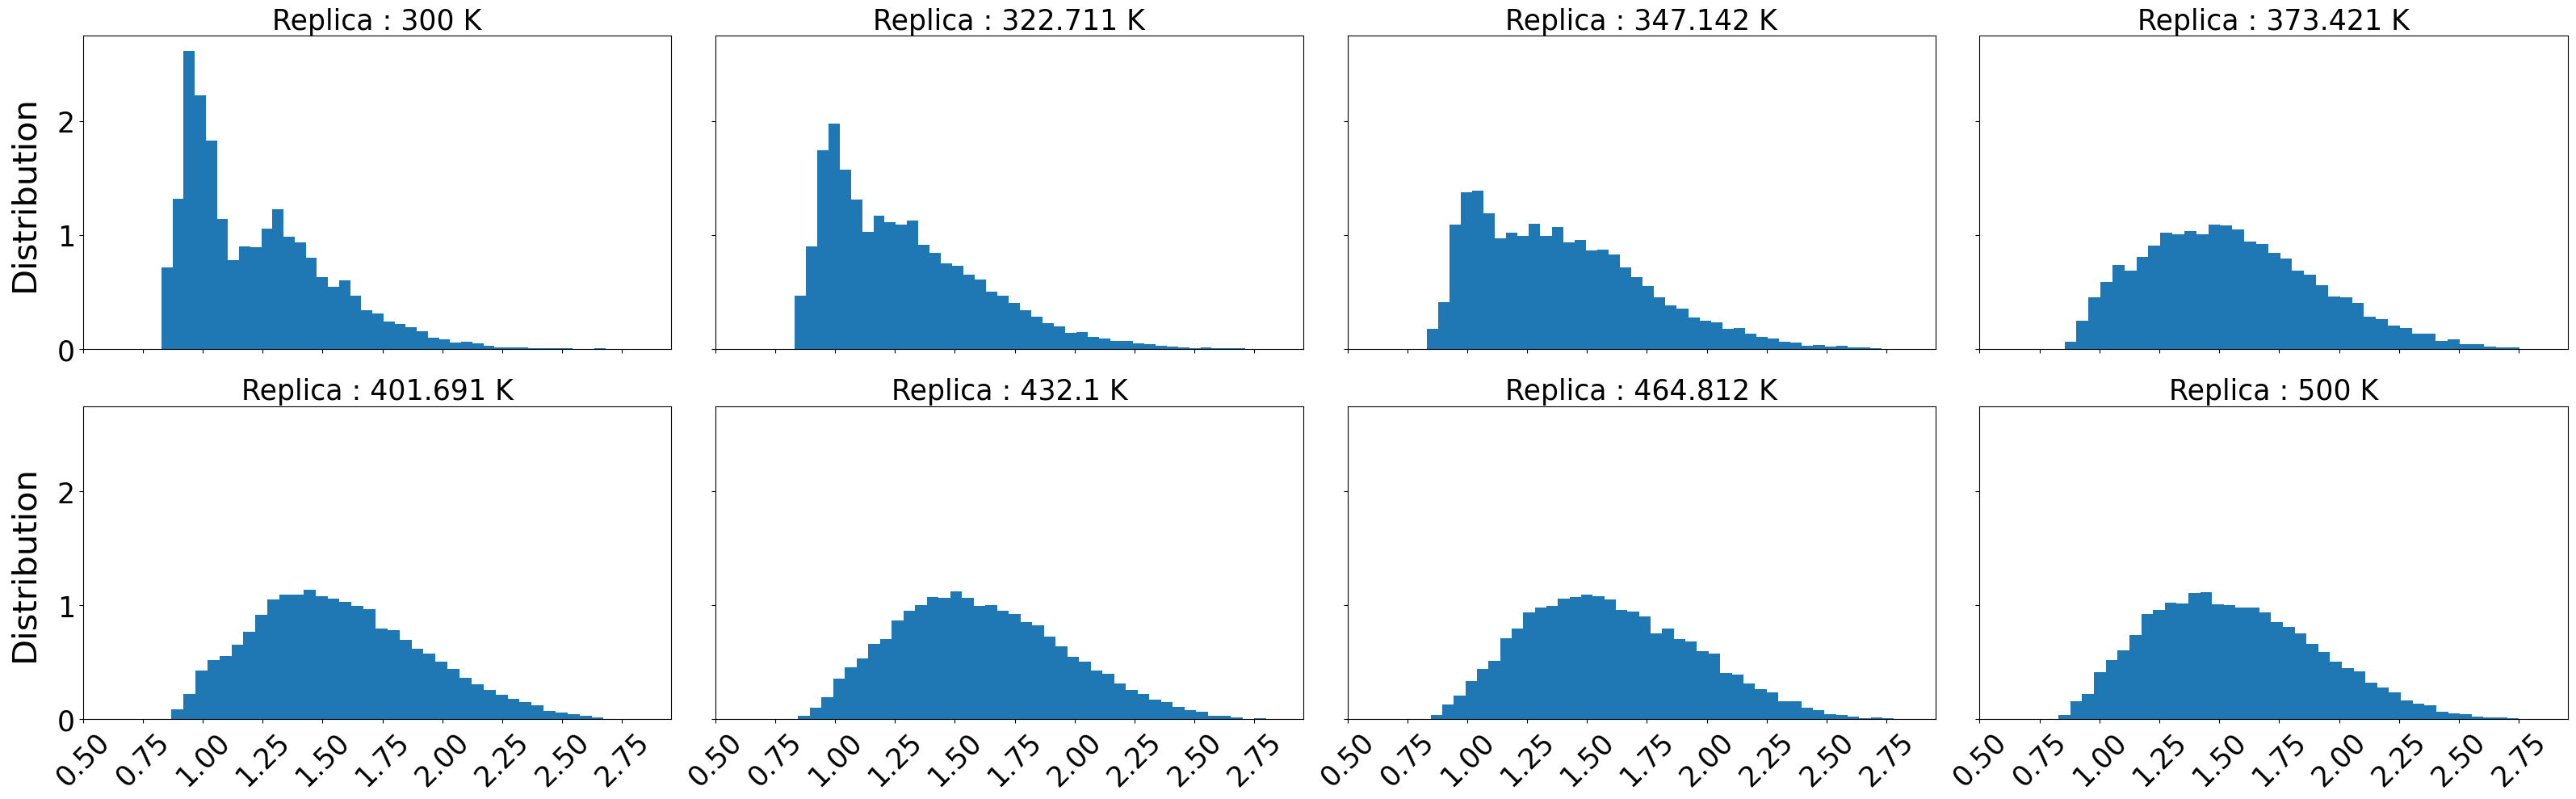

In [28]:
fig, ax = plt.subplots(2, 4, figsize=(32, 10), sharex=True, sharey=True)

i='rep'
N=200

for val in range(nrep):
    p, q = np.unravel_index(val,(2, 4))
    
    ax[p,q].hist(np.array(rg[i])[val], bins=40, density=True)
    
    ax[p,q].tick_params(labelsize=25)
    plt.setp(ax[p,q].get_xticklabels(), rotation=45)
#    ax[p,q].set_ylim(0.6,2.0)
    ax[p,q].set_xticks(np.arange(0.5,3.0,0.25))
#    ax[p,q].set_yticks(np.arange(0.6,2.2,0.4))
    
    ax[p,q].set_title('Replica : '+temperature[val]+' K',size=25)

    if not q : ax[p,q].set_ylabel("Distribution", size=30, labelpad=15)
    if p == 4-1 : ax[p,q].set_xlabel('Rg (nm)', size=30, labelpad=15)
        
plt.tight_layout()

plt.savefig(data_dir+'rg_hist_rep.png',dpi=210)

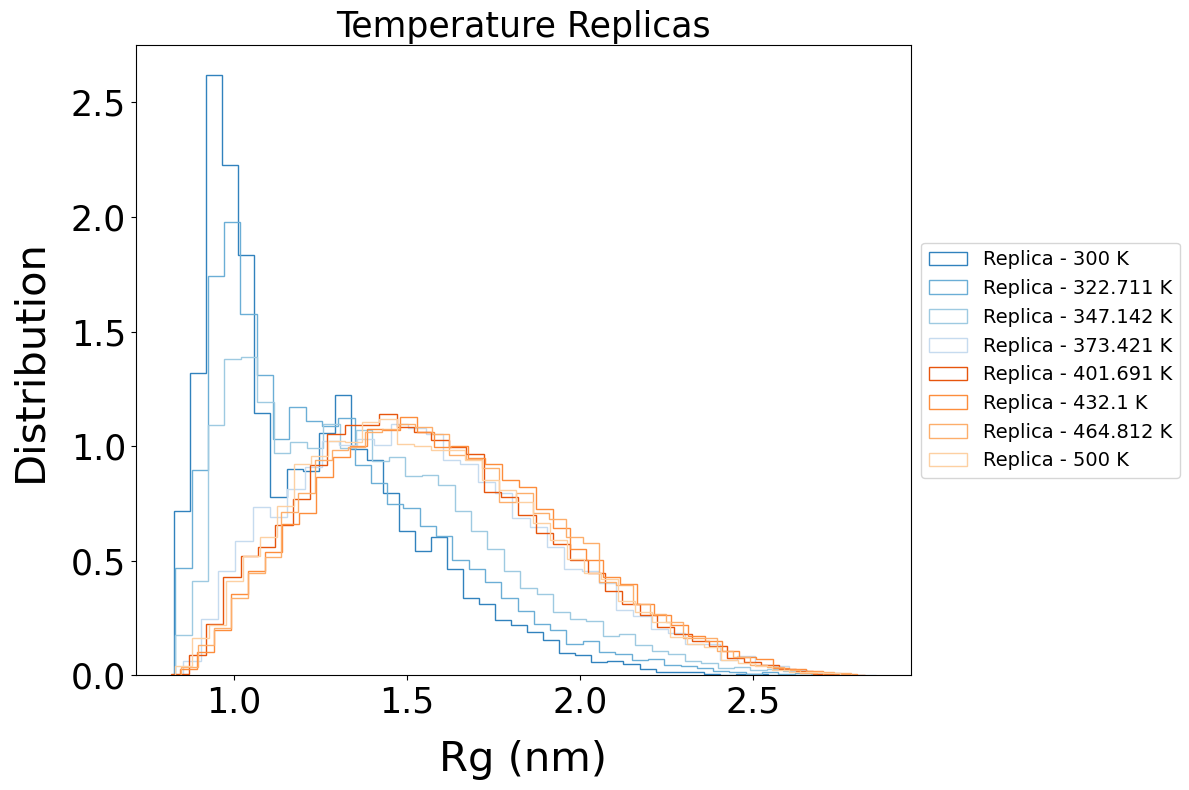

In [29]:
plt.figure(figsize=(12,8))

i='rep'

for val in range(nrep):
    if i=='rep': 
        label_="Replica - "+str(temperature[val])+' K'  
    else:
        label_="Demux Replica - "+str(val)
    
    plt.hist(np.array(rg[i])[val],bins=40,density=True,histtype='step',color=plt.cm.tab20c(val),label=label_)
    
    plt.tick_params(labelsize=25)
    plt.setp(ax[p,q].get_xticklabels(), rotation=45)
    #ax[p,q].set_ylim(1,4)
    #ax[p,q].set_xticks(range(0,142,2))
    #ax[p,q].set_yticks(np.arange(1.0,4.0,0.4))
    
plt.title('Temperature Replicas',size=25)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.ylabel("Distribution", size=30, labelpad=15)
plt.xlabel('Rg (nm)', size=30, labelpad=15)
        
plt.tight_layout()

plt.savefig(data_dir+'rg_rep_hist_all.png',dpi=210)

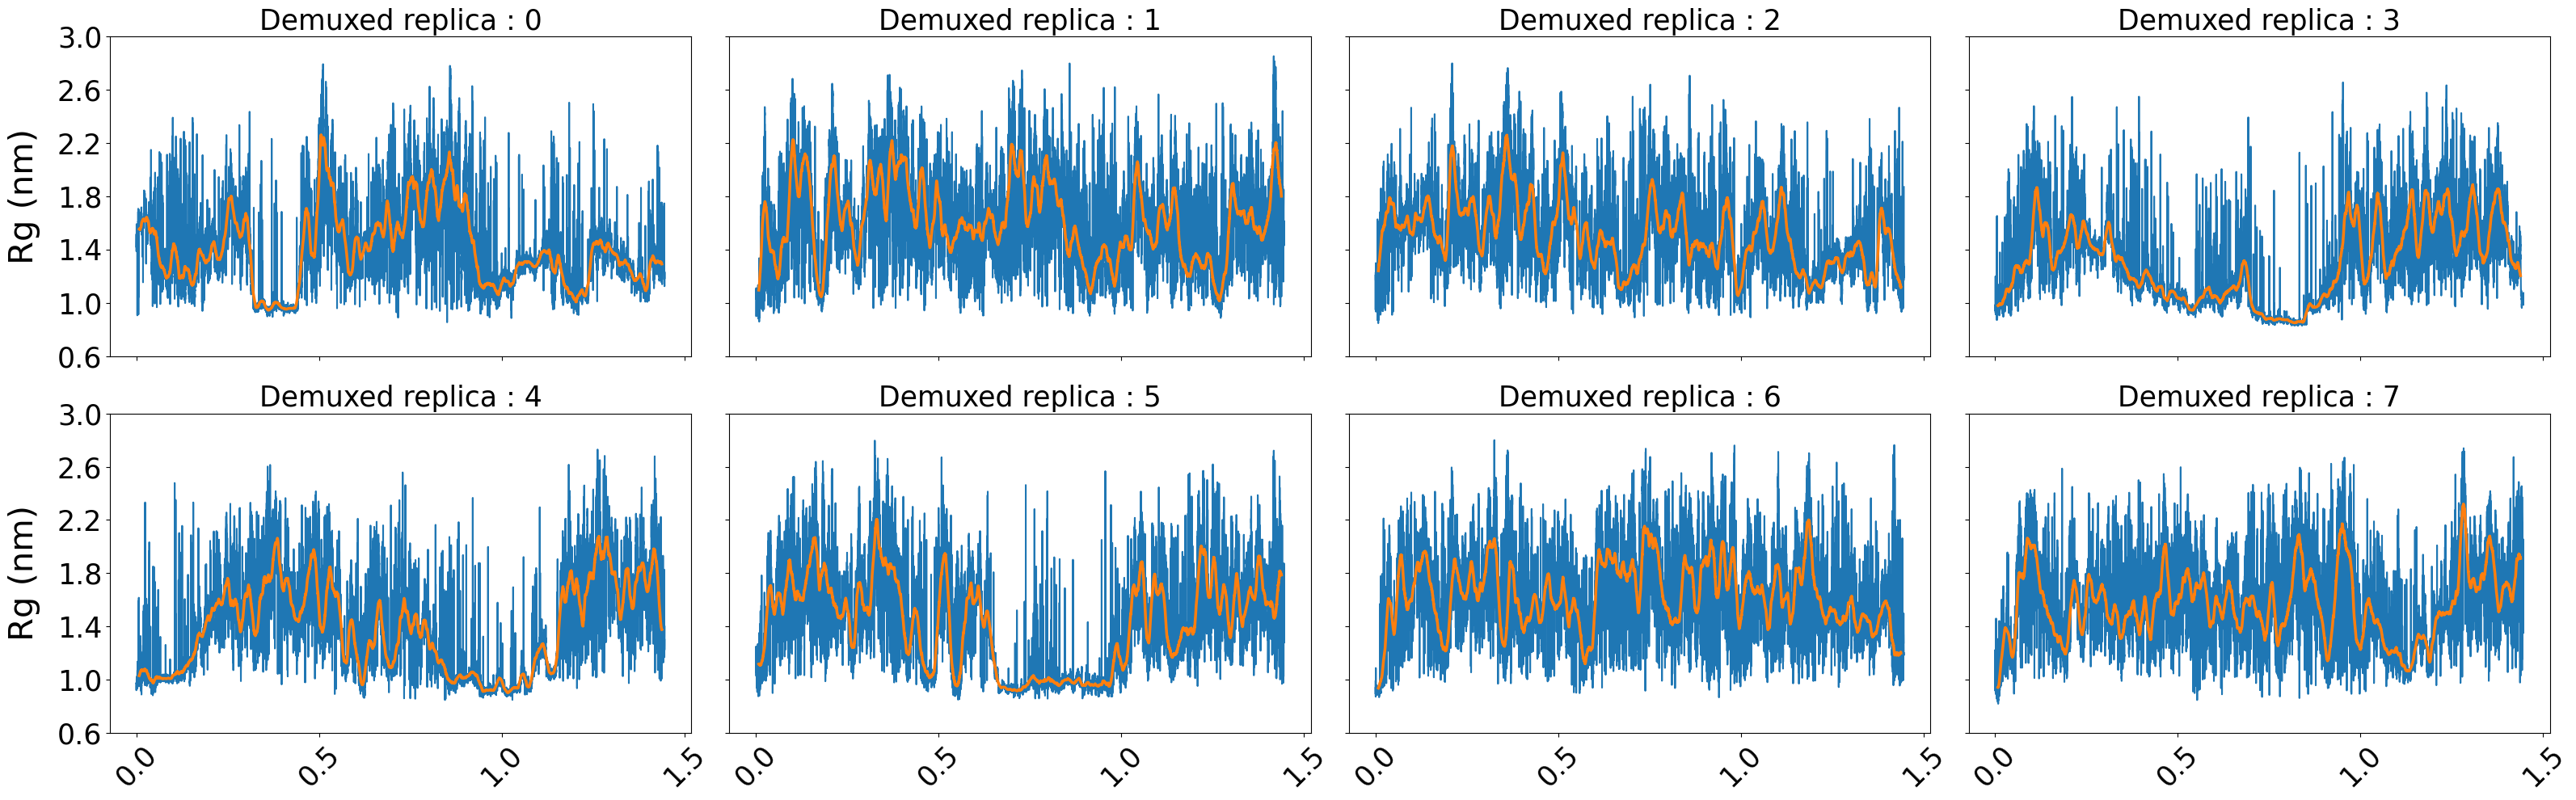

In [30]:
fig, ax = plt.subplots(2, 4, figsize=(32, 10), sharex=True, sharey=True)

i='demux'
N=200

for val in range(nrep):
    p, q = np.unravel_index(val,(2, 4))
    
    ax[p,q].plot(time,np.array(rg[i])[val])
    ax[p,q].plot(np.convolve(time, np.ones(N)/N, mode='valid'),
                 np.convolve(np.array(rg[i])[val], np.ones(N)/N, mode='valid'),linewidth=2.5)
    
    ax[p,q].tick_params(labelsize=25)
    plt.setp(ax[p,q].get_xticklabels(), rotation=45)
    ax[p,q].set_ylim(0.6,3.0)
    #ax[p,q].set_xticks(range(0,142,2))
    ax[p,q].set_yticks(np.arange(0.6,3.2,0.4))
    
    ax[p,q].set_title('Demuxed replica : '+str(val),size=25)

    if not q : ax[p,q].set_ylabel("Rg (nm)", size=30, labelpad=15)
    if p == 4-1 : ax[p,q].set_xlabel('Time ($\mu$s)', size=30, labelpad=15)
        
plt.tight_layout()

plt.savefig(data_dir+'rg_demux.png',dpi=210)

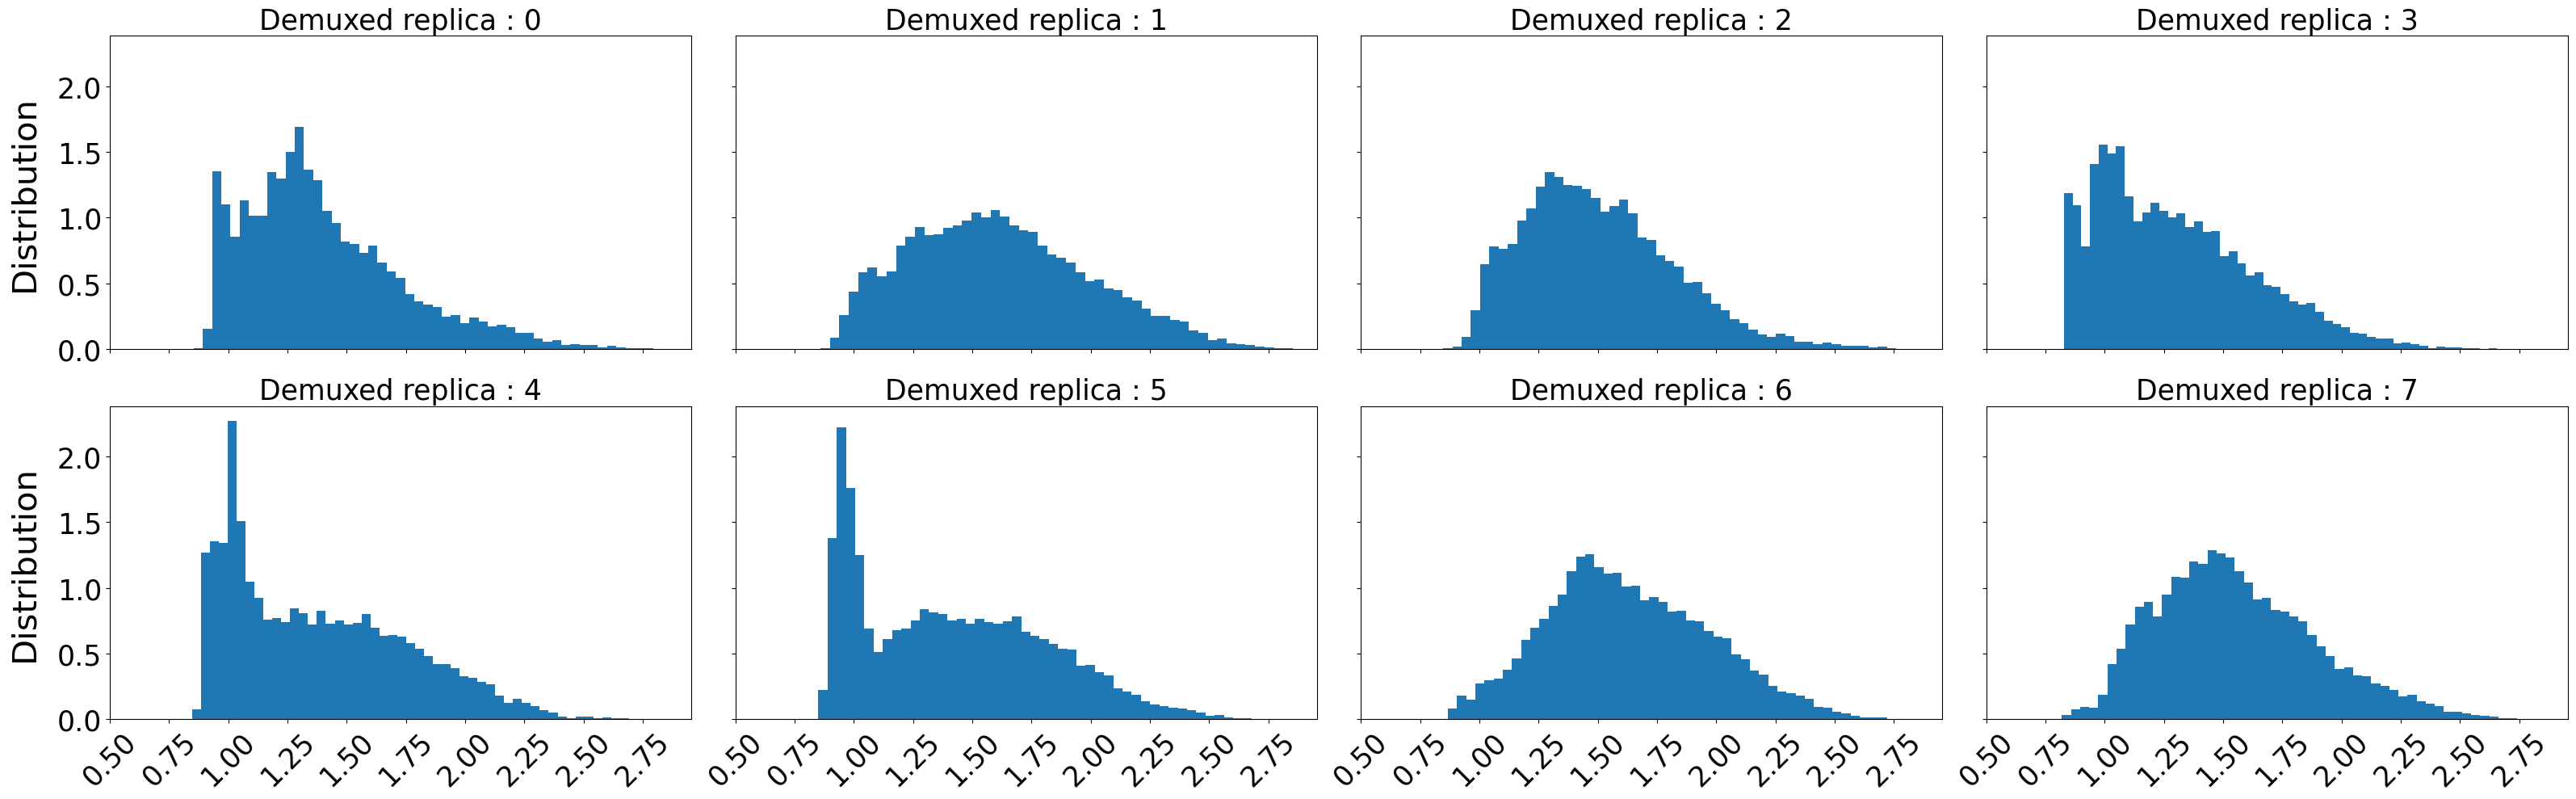

In [32]:
fig, ax = plt.subplots(2,4, figsize=(32, 10), sharex=True, sharey=True)

i='demux'
N=200

for val in range(nrep):
    p, q = np.unravel_index(val,(2, 4))
    
    ax[p,q].hist(np.array(rg[i])[val], bins=50, density=True)
    
    ax[p,q].tick_params(labelsize=25)
    plt.setp(ax[p,q].get_xticklabels(), rotation=45)
#    ax[p,q].set_ylim(0.6,2.0)
    ax[p,q].set_xticks(np.arange(0.5,3.0,0.25))
#    ax[p,q].set_yticks(np.arange(0.6,2.2,0.4))
    
    ax[p,q].set_title('Demuxed replica : '+str(val),size=25)


    if not q : ax[p,q].set_ylabel("Distribution", size=30, labelpad=15)
    if p == 4-1 : ax[p,q].set_xlabel('Rg (nm)', size=30, labelpad=15)
        
plt.tight_layout()

plt.savefig(data_dir+'rg_hist_demux.png',dpi=210)

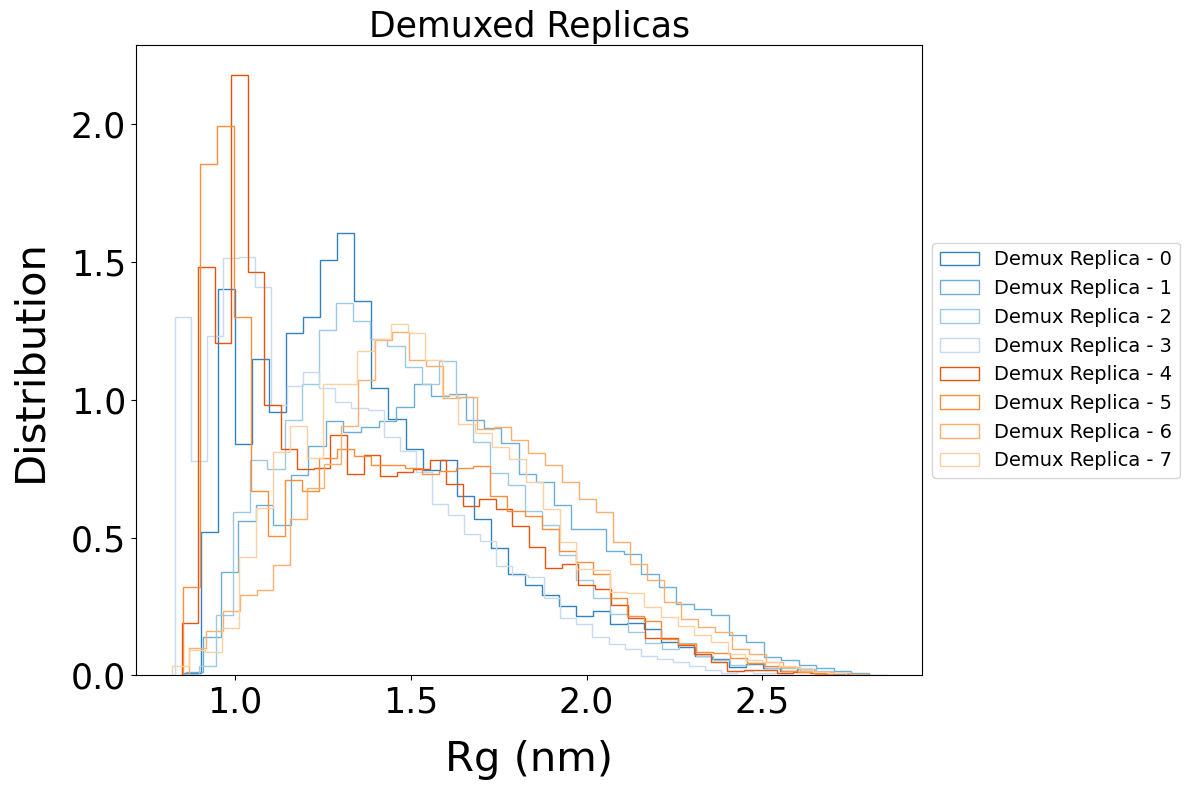

In [33]:
plt.figure(figsize=(12,8))

i='demux'

for val in range(nrep):
    
    if i=='rep': 
        label_="Replica - "+str(temperature[val])+' K'  
    else:
        label_="Demux Replica - "+str(val)
    
    plt.hist(np.array(rg[i])[val],bins=40,density=True,histtype='step',color=plt.cm.tab20c(val),label=label_)
    
    plt.tick_params(labelsize=25)
    plt.setp(ax[p,q].get_xticklabels(), rotation=45)
    #ax[p,q].set_ylim(1,4)
    #ax[p,q].set_xticks(range(0,142,2))
    #ax[p,q].set_yticks(np.arange(1.0,4.0,0.4))
    
plt.title('Demuxed Replicas',size=25)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.ylabel("Distribution", size=30, labelpad=15)
plt.xlabel('Rg (nm)', size=30, labelpad=15)
        
plt.tight_layout()

plt.savefig(data_dir+'rg_demux_hist_all.png',dpi=210)

In [34]:
data={}

data['temp']=np.loadtxt("./replica_temp.xvg",comments=['@','#'])
data['index']=np.loadtxt("./replica_index.xvg",comments=['@','#'])

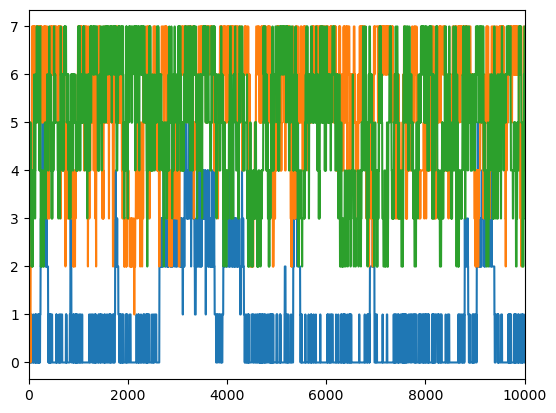

In [35]:
for i in range(1,4):
    plt.plot(data['temp'].T[i])
    
    plt.xlim(0,10000)

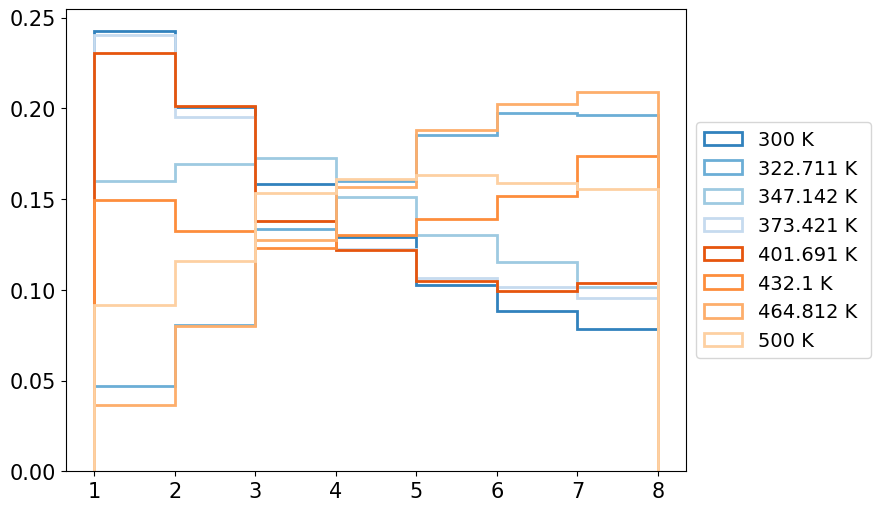

In [36]:
# My code
plt.figure(figsize=(8,6))
for i in range(1,nrep+1):
    plt.hist(data['temp'].T[i],range= (1,nrep),histtype='step',density='true',linewidth=2,
             color=plt.cm.tab20c(i-1),label=str(temperature[i-1]) + " K ",bins=nrep-1)
    
plt.tick_params(labelsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

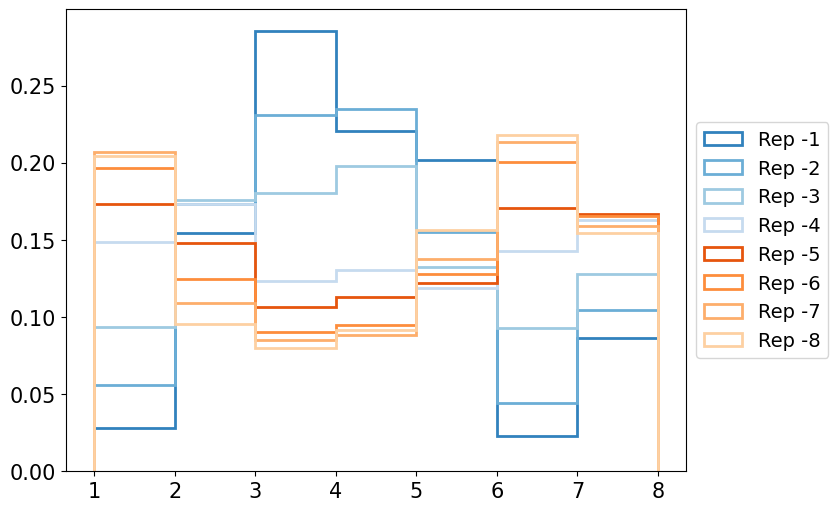

In [44]:
# My code
plt.figure(figsize=(8,6))
for i in range(1,nrep+1):
    plt.hist(data['index'].T[i],range= (1,nrep),histtype='step',density='true',linewidth=2,
             color=plt.cm.tab20c(i-1),label="Rep -"+str(i),bins=nrep-1)
    
plt.tick_params(labelsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

In [45]:
prob=[]
b=0
for i in range(nrep):
#     a=(np.where(data['temp'].T[1]==i)[0].shape[0])/(data['temp'].shape[0])
    a=(np.where(data['temp'].T[i+1]==0)[0].shape[0])/(data['temp'].shape[0])
    prob.append(a)
    print(i,a)
    b=b+a
print(f'Probability check : {b}')


0 0.23924502165268519
1 0.021414804373466222
2 0.11768350567705302
3 0.21696499501003524
4 0.16795712392151482
5 0.15355150506630788
6 0.017269039868822566
7 0.06591400443011504
Probability check : 1.0


Text(0.5, 1.0, 'From replica_temp.xvg to replica-0')

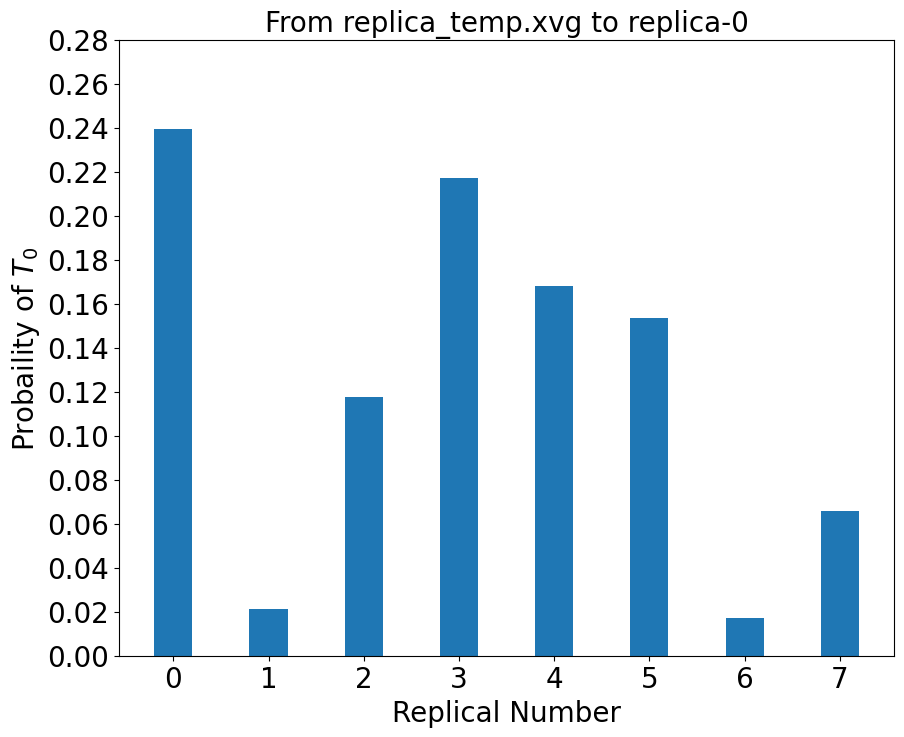

In [46]:
plt.figure(figsize=(10,8))
plt.bar(range(nrep),prob,width = 0.4)
plt.xticks(range(nrep),size=20)
plt.yticks(np.arange(0,0.3,0.02),size=20)
plt.ylabel(r'Probaility of $T_{0}$',size=20)
plt.xlabel('Replical Number',size=20)
plt.title('From replica_temp.xvg to replica-0',size=20)

In [47]:
T_mean=[]

for j in range(1,nrep+1):
    replica_T=[]
    for i in data['temp'].T[j]:
        replica_T.append(float(temperature[int(i)]))
    
    T_mean.append(np.mean(replica_T))
        

Text(0.5, 1.0, 'Mean replica temperature')

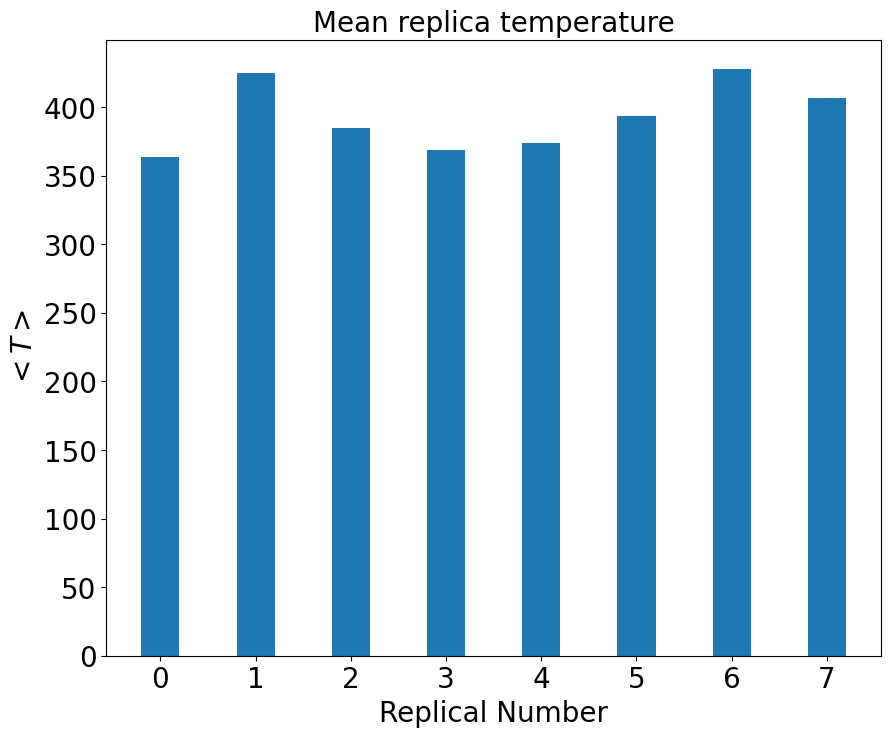

In [48]:
plt.figure(figsize=(10,8))
plt.bar(range(nrep),T_mean,width = 0.4)
plt.xticks(range(nrep),size=20)
plt.yticks(size=20)
plt.ylabel(r'$<T>$',size=20)
plt.xlabel('Replical Number',size=20)
plt.title('Mean replica temperature',size=20)

In [49]:
# calculate round trip times stack
def calc_round_trip_stack(file, nreps = 20 ):
    """
    xvg = the temp xvg file with the exchanges at every 80ps
    """
    # unpack the xvg file 
    rep_dict = {} # for counting 
    xvg = np.loadtxt(file ,comments=["@", "#"])[:,1:]

    for i in range(nreps): 
        rep = xvg[:,i]
        rep_dict[i] = 0 
        stack = []
        for e in rep:
            # reinstantiate list 
            if len(stack) == nreps: 
                rep_dict[i] += 0.5
                stack = []
            elif int(e) not in stack: 
                stack.append(int(e))
    
    return rep_dict

# Old Rt code
def calc_round_trip_stack_2(file, nreps=20):
    
    n=0
    d=0
    # rt=0
    rep_dict={}
    rep=[i for i in range(nreps)]

    data=np.loadtxt(file ,comments=["@", "#"])[:,1:]

    for i in rep:
        rep_dict[i] = 0
        stack = []

        for e in data.T[i]:

            n+=1
            if int(e) not in stack:
                stack.append(int(e))
                
            if e == nreps-1:
                d=1
                
            if e == 0 and d == 1:
                
                d=0
                rep_dict[i]+=1
                stack = []
                
    return rep_dict


In [50]:
nreps=[8]

file_list=['./replica_temp.xvg']

In [51]:
rt_dict=calc_round_trip_stack(file_list[0],nreps=nreps[0])

Text(0.5, 0, 'Replical Number')

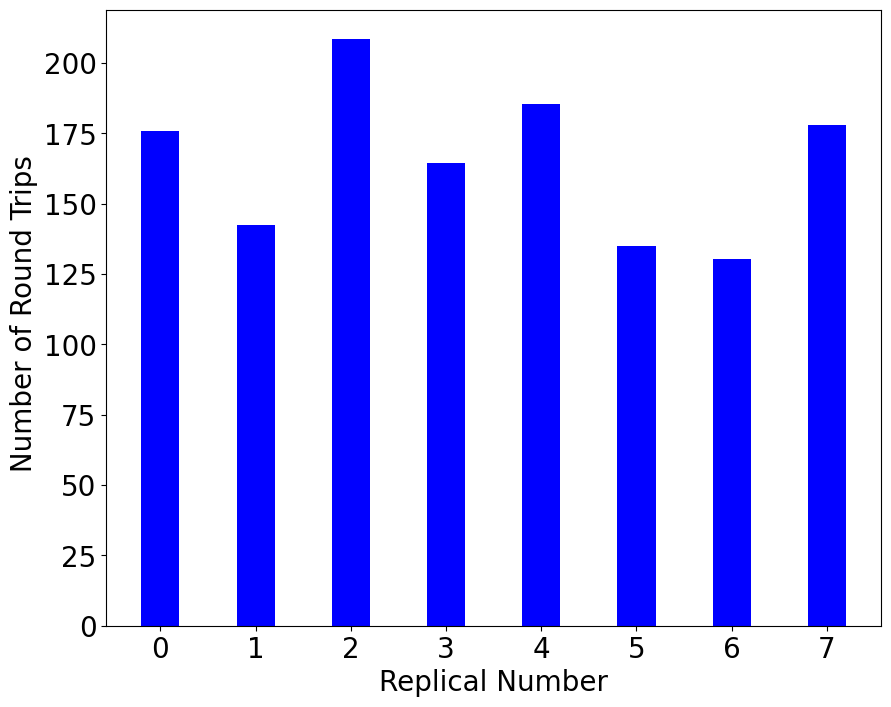

In [52]:
plt.figure(figsize=(10,8))

for i in range(nrep):
    plt.bar(i,rt_dict[i],width = 0.4,color='b')
    
# plt.axhline(y=np.mean(r_trip),color='grey')
plt.xticks(range(nrep),size=20)
plt.yticks(size=20)
plt.ylabel(r' Number of Round Trips',size=20)
plt.xlabel('Replical Number',size=20)
#plt.title('',size=20)

In [53]:
rt_dict=calc_round_trip_stack_2(file_list[0],nreps=nreps[0])

Text(0.5, 0, 'Replical Number')

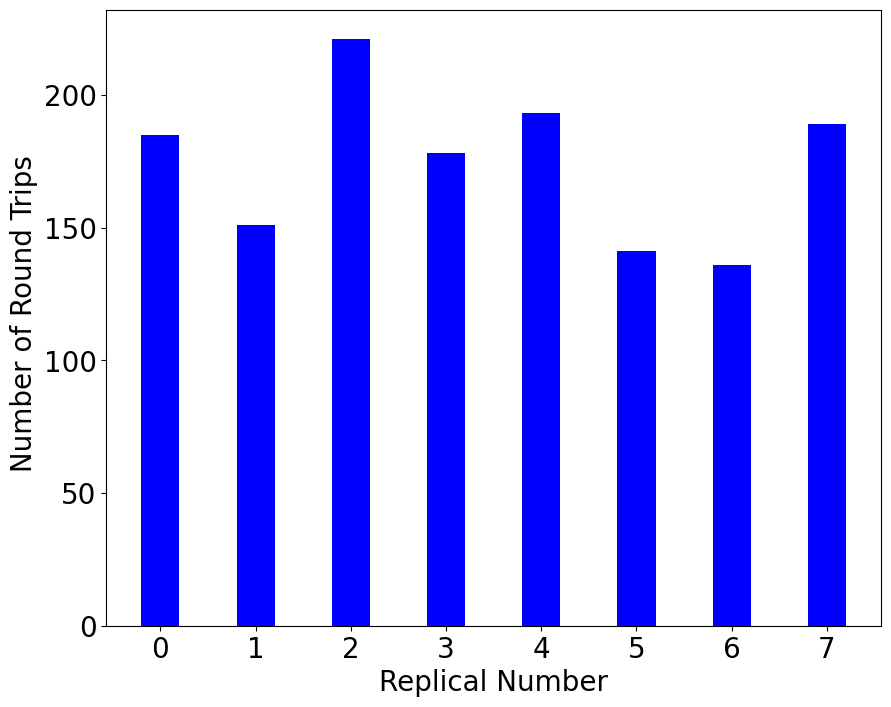

In [54]:
plt.figure(figsize=(10,8))

for i in range(nrep):
    plt.bar(i,rt_dict[i],width = 0.4,color='b')
    
# plt.axhline(y=np.mean(r_trip),color='grey')
plt.xticks(range(nrep),size=20)
plt.yticks(size=20)
plt.ylabel(r' Number of Round Trips',size=20)
plt.xlabel('Replical Number',size=20)
#plt.title('',size=20)